In [1]:
# step pertama - import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!\n")

All libraries imported successfully!



In [2]:
# step kedua - load datasets

print("LOADING DATASET : ")
df = pd.read_csv('nilai-gizi.csv')
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns\n")
print("First 5 rows:")
display(df.head())

LOADING DATASET : 
Dataset loaded: 1651 rows × 22 columns

First 5 rows:


,name,manufacturer,serving_size,energy_kcal,protein_g,carbohydrate_g,fat_g,sugar_g,sodium_mg,fiber_g,...,carbohydrate_percentage_dv,fat_percentage_dv,sodium_percentage_dv,Lemak jenuh,Natrium,Protein,Karbohidrat total,Energi,Lemak total,Serat pangan
0,"Ikan sunu, asin, mentah",Tidak Diketahui,20.30 g,199.0,34.1,7.1,3.8,0.0,377.0,0.0,...,2.18,5.67,25.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Soto pekalongan, masakan",Tidak Diketahui,1.30 g,94.0,3.0,5.1,6.8,0.0,0.0,0.3,...,1.57,10.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Marie duo,Tidak Diketahui,1 g,15.0,1.0,14.0,3.5,5.0,85.0,1.0,...,4.31,5.22,5.67,10.0,6.0,0.0,0.0,0.0,0.0,0.0
3,"Kaparende, sayur",Tidak Diketahui,1.30 g,38.0,2.4,2.6,2.0,0.0,170.0,1.5,...,0.80,2.99,11.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Kacang lebui / iris,Tidak Diketahui,3.60 g,346.0,16.5,66.6,1.5,0.0,17.0,37.3,...,20.49,2.24,1.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CREATING FLEXIBLE DIABETES SCORING SYSTEM (5 CATEGORIES)

Category Distribution:
category_label
Moderate     269
Good         242
Excellent    924
Caution      157
Avoid         59
Name: count, dtype: int64

Percentage:
category_label
Moderate     16.293156
Good         14.657783
Excellent    55.966081
Caution       9.509388
Avoid         3.573592
Name: proportion, dtype: float64


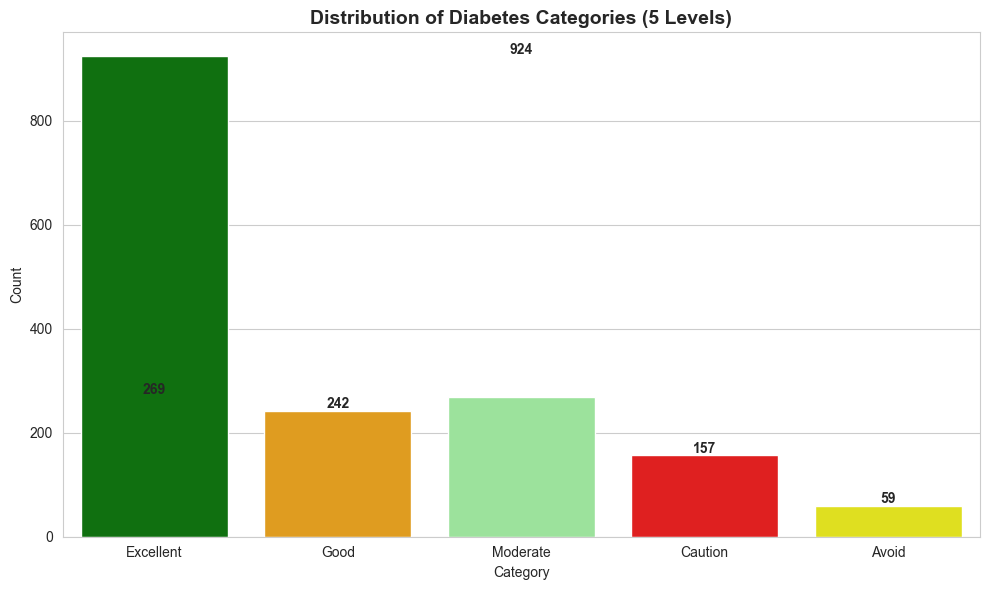

In [4]:
# step ketiga - membuat scoring sistem diabetes yang fleksibel

print("CREATING FLEXIBLE DIABETES SCORING SYSTEM (5 CATEGORIES)")


def calculate_diabetes_score(row):
    """
    Hitung skor diabetes berdasarkan nilai gizi.
    Skor rendah = lebih aman untuk diabetes
    """
    score = 0
    
    # SUGAR IMPACT (bobot 35%)
    sugar = row['sugar_g']
    if sugar <= 5:
        score += 0
    elif sugar <= 10:
        score += 10
    elif sugar <= 15:
        score += 20
    elif sugar <= 25:
        score += 35
    else:
        score += 50
    
    # CARBOHYDRATE IMPACT (bobot 30%)
    carbs = row['carbohydrate_g']
    if carbs <= 15:
        score += 0
    elif carbs <= 30:
        score += 10
    elif carbs <= 45:
        score += 20
    elif carbs <= 60:
        score += 30
    else:
        score += 40
    
    # ENERGY/CALORIE IMPACT (bobot 20%)
    calories = row['energy_kcal']
    if calories <= 150:
        score += 0
    elif calories <= 250:
        score += 5
    elif calories <= 350:
        score += 12
    elif calories <= 500:
        score += 18
    else:
        score += 25
    
    # FIBER BONUS (bobot -15%)
    fiber = row['fiber_g']
    if fiber >= 5:
        score -= 15
    elif fiber >= 3:
        score -= 10
    elif fiber >= 1:
        score -= 5
    
    # FAT CONSIDERATION (bobot 10%)
    fat = row['fat_g']
    if fat > 20:
        score += 10
    elif fat > 15:
        score += 5
    
    return max(0, score)

# Hitung skor
df['diabetes_score'] = df.apply(calculate_diabetes_score, axis=1)

# Kategorisasi 5 level
def categorize_diabetes_safety(score):
    if score <= 15:
        return 4  # Excellent
    elif score <= 30:
        return 3  # Good
    elif score <= 50:
        return 2  # Moderate
    elif score <= 70:
        return 1  # Caution
    else:
        return 0  # Avoid

df['diabetes_category'] = df['diabetes_score'].apply(categorize_diabetes_safety)

category_labels = {
    4: 'Excellent',
    3: 'Good', 
    2: 'Moderate',
    1: 'Caution',
    0: 'Avoid'
}

df['category_label'] = df['diabetes_category'].map(category_labels)

print("\nCategory Distribution:")
print(df['category_label'].value_counts().sort_index(ascending=False))
print("\nPercentage:")
print(df['category_label'].value_counts(normalize=True).sort_index(ascending=False) * 100)

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category_label', hue='category_label',
              order=['Excellent', 'Good', 'Moderate', 'Caution', 'Avoid'],
              palette=['green', 'lightgreen', 'yellow', 'orange', 'red'],
              legend=False)
plt.title('Distribution of Diabetes Categories (5 Levels)', fontweight='bold', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Count')
for i, v in enumerate(df['category_label'].value_counts().sort_index(ascending=False).values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# step keempat - feature section

print("FEATURE SELECTION")

numerical_features = [
    'serving_size', 'energy_kcal', 'protein_g', 'carbohydrate_g', 
    'fat_g', 'sugar_g', 'sodium_mg', 'fiber_g'
]

available_features = [col for col in numerical_features if col in df.columns]

print(f"Selected Features ({len(available_features)}):")
for i, feat in enumerate(available_features, 1):
    print(f"  {i}. {feat}")

# Bersihkan data dulu, hapus satuan kayak 'g', 'mg', dll
for col in available_features:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')


X = df[available_features].fillna(df[available_features].median())
y = df['diabetes_category']

print(f"\nFeature matrix (X): {X.shape}")
print(f"Target vector (y): {y.shape}")

FEATURE SELECTION
Selected Features (8):
  1. serving_size
  2. energy_kcal
  3. protein_g
  4. carbohydrate_g
  5. fat_g
  6. sugar_g
  7. sodium_mg
  8. fiber_g

Feature matrix (X): (1651, 8)
Target vector (y): (1651,)


In [7]:
# step 5 - train test split & scaling

print("DATA PREPROCESSING")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

DATA PREPROCESSING
Training set: 1320 samples
Testing set: 331 samples
Feature scaling completed


TRAINING RANDOM FOREST CLASSIFIER (5 CATEGORIES)
Training model...
Training completed!

Accuracy: 0.8943 (89.43%)

Classification Report:
              precision    recall  f1-score   support

       Avoid       0.91      0.83      0.87        12
     Caution       0.87      0.84      0.85        31
    Moderate       0.73      0.85      0.79        54
        Good       0.82      0.63      0.71        49
   Excellent       0.97      0.99      0.98       185

    accuracy                           0.89       331
   macro avg       0.86      0.83      0.84       331
weighted avg       0.90      0.89      0.89       331



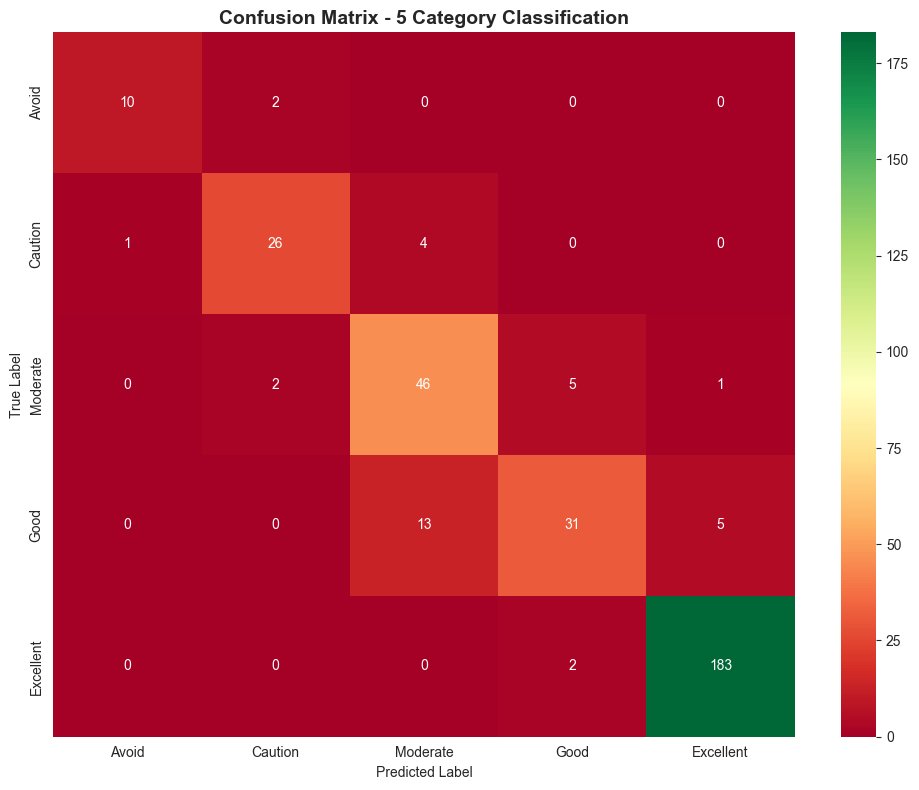


Feature Importance:


,Feature,Importance
5,sugar_g,0.245024
3,carbohydrate_g,0.234785
1,energy_kcal,0.199336
4,fat_g,0.088124
2,protein_g,0.068779
7,fiber_g,0.067046
0,serving_size,0.056769
6,sodium_mg,0.040137


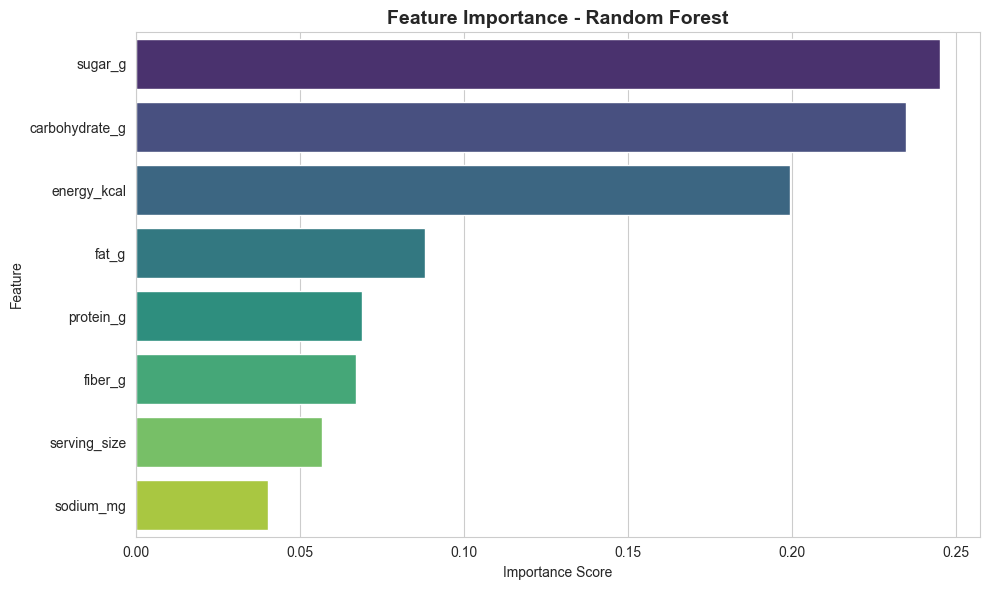

In [9]:
# step keenam - train random forest 

print("TRAINING RANDOM FOREST CLASSIFIER (5 CATEGORIES)")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=3,
    random_state=42,
    class_weight='balanced'
)

print("Training model...")
rf_model.fit(X_train_scaled, y_train)
print("Training completed!")

y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nClassification Report:")
target_names = ['Avoid', 'Caution', 'Moderate', 'Good', 'Excellent']
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - 5 Category Classification', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Feature Importance - Random Forest', fontweight='bold', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [10]:
# step ketujuh - menyimpan model 

print("SAVING MODEL AND PREPROCESSOR")

joblib.dump(rf_model, 'best_diabetes_food_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(available_features, 'feature_names.pkl')

print("Model saved: best_diabetes_food_model.pkl")
print("Scaler saved: scaler.pkl")
print("Features saved: feature_names.pkl")

SAVING MODEL AND PREPROCESSOR
Model saved: best_diabetes_food_model.pkl
Scaler saved: scaler.pkl
Features saved: feature_names.pkl


In [11]:
# step kedelapan - prediction function 

print("PREDICTION FUNCTION")

def predict_diabetes_safety(input_dict):
    """
    Predict diabetes safety category (5 levels)
    """
    input_df = pd.DataFrame([input_dict])
    
    for feature in available_features:
        if feature not in input_df.columns:
            raise ValueError(f"Missing feature: {feature}")
    
    input_df = input_df[available_features]
    input_scaled = scaler.transform(input_df)
    
    prediction_label = rf_model.predict(input_scaled)[0]
    probabilities = rf_model.predict_proba(input_scaled)[0]
    
    all_probs = {}
    for idx in range(len(probabilities)):
        all_probs[category_labels[idx]] = float(probabilities[idx] * 100)
    
    recommendations = {
        4: "✓ Sangat aman! Boleh konsumsi regular.",
        3: "✓ Aman untuk dikonsumsi. Pilihan bagus.",
        2: "⚠ Boleh sesekali, perhatikan porsi.",
        1: "⚠ Batasi konsumsi, pilih alternatif lebih sehat.",
        0: "✗ Hindari atau konsumsi sangat jarang."
    }
    
    result = {
        'category': category_labels[prediction_label],
        'category_code': int(prediction_label),
        'confidence': float(probabilities[prediction_label] * 100),
        'all_probabilities': all_probs,
        'recommendation': recommendations[prediction_label]
    }
    
    return result

print("Prediction function created!")

PREDICTION FUNCTION
Prediction function created!
